# Week 9: Metropolis Monte Carlo

## 1. Introduction
As has been described in the lecture, a Monte Carlo simulation is one that invokes some sort of randomness to estimate some value or solve a problem.  One popular implementation of Monte Carlo is the Metropolis-Hastings algorithm, which employs some energy function to evaluate the progress of the system, and either accepts or rejects random actions based on how it impacts the energy of the system.  If the energy change is favorable, i.e. negative, the action will unconditionally be accepted.  However, if the energy change is unfavorable, i.e. positive, the action will be accepted according to the "Metropolis Criterion":
<center>$p(accept)=e^{-\frac{\Delta E}{RT}}$</center>
Where $\Delta E$ is the change in energy and $RT$ is a term describing simulation temperature.  In this exercise, you will be implementing your own Metropolis Monte Carlo simulation to pack a set of circles toward the origin.

(Insert illustrative figure here)

Before proceeding, run the following code so that all the necessary functions and packages are defined.

In [8]:
#
#Packages needed to properly run the notebook
#
import matplotlib.pyplot as p
import random
import math
from copy import deepcopy
from ipywidgets import interact, fixed

#
#Instructor-given functions
#

#distance calculates the euler's distance between any two points
def distance(pointA,pointB):
    return math.sqrt(sum([(pointA[i]-pointB[i])**2 for i in range(len(pointA))]))

#showPlot is needed to visualize the MC simulation result
def showPlot(index,pointStates,energies):
    pointCount=len(pointStates[index])
    points=pointStates[index]
    p.scatter([i[0] for i in points],[i[1] for i in points])
    p.xlim(-5*pointCount,5*pointCount)
    p.ylim(-5*pointCount,5*pointCount)
    p.show()
    print("Total system energy: %.2f"%energies[index])

#temperatureCurve is needed to generate the simulated annealing temperatures
def temperatureCurve(maxtemp,mcsteps):
    toptemp=maxtemp
    currtemp=toptemp
    temps=[]
    tempstep=(toptemp*(toptemp+1))/(2*mcsteps)
    for i in range(mcsteps):
        temps.append(currtemp)
        currtemp-=tempstep
        if currtemp-1e-4 <= 0.:
            maxtemp-=1.0
            currtemp=maxtemp
    p.plot([i for i in range(mcsteps)],temps)
    p.xlabel("MC step")
    p.ylabel("Temperature")
    p.show()
    return temps

## 2. Initializing the System
The first step to designing the simulation is to initialize the system to be simulated.  The initial system is defined as a set of $N$ 2D points randomly distributed inside a square centered on the origin whose sides are $10*N$ long.  Construct the function *initializeSystem*, which takes in a single argument corresponding to the number of points and returns an $N$x$2$ multidimensional array of coordinates for the points. (Hint: if you aren't sure how to randomly generate values, read the documentation for Python's *random* package: https://docs.python.org/2/library/random.html)

In [2]:
def initializeSystem(pointCount):
    boxDimensions=10*pointCount
    points=[[random.uniform(-boxDimensions/2,boxDimensions/2) for j in range(2)] for i in range(pointCount)]
    return points

## 3. Designing the Energy Function
Once we have an observable state for the system (i.e. the initial state), we need to be able to evaluate the total energy of the system.  In protein structure modeling, the function used to calculate this energy can have as many as ~10-20 terms that each take unique physical forces and statistical likelihoods into account.  Since this is a simple simulation, the energy function will only consist of two terms:

<center>$E=E_{center}+E_{radius}$</center>

$E_{center}$ is defined as the sum of each point's distance from the origin, $(0,0)$.  Since the objective of the Monte Carlo simulation is to minimize the energy, this energy term will drive the collapse of the points towards the origin.  $E_{radius}$ is a term which ensures that all points don't end up overlapping each other and instead keep some amount of distance away from each other.  This term is analogous to Van der Waals repulsion energy from protein modeling, which ensures that protein residues don't engage in steric clashes.  This energy term will provide some constant penalty value to the energy for each pair of points that are positioned closer than the sum of their radii.  In summary:

<center>$E_{center}=\sum_{i=0}^{N}{d_{i,(0,0)}}$</center>
<center>$E_{radius}=\sum_{i=0}^{N}{\sum_{j=i+1}^{N}{c*\mathbb{I}(d_{i,j}<2r)}}$

where $d_{i,(0,0)}$ is each point $i$'s distance from the origin, $c$ is the penalty constant, $d_{i,j}$ is the distance between points $i$ and $j$, $r$ is the radius of each point, and $\mathbb{I}$ is the indicator function. While the constants can take any value, it is suggested that you set $r=1,c=10$.  Given this definition, construct the function *calculateEnergy* which takes an $N$x$2$ multidimensional array of coordinates, calculates $E_{center}$ and $E_{radius}$, and returns their sum.  (Hint: recall that the distance function is already provided by the instructor)

In [3]:
def calculateEnergy(points):
    radius=1.
    E_radius=0.
    for i in range(len(points)):
        for j in range(i+1,len(points)):
            if distance(points[i],points[j]) < radius*2:
                E_radius+=10.
    
    E_center=0.
    for point in points:
        E_center+=distance(point,[0.,0.,0.])
    return E_radius+E_center

## 4. Implementing Movement
Now that we have a way to evaluate states of the system, we can create a function that will generate new states by randomly moving individual points.  In typical protein modeling simulations, many different movements can occur, but this simulation will only include one: moving a randomly chosen point a constant distance in a random direction.  In order words, this function will choose a random point and translate it according to a randomly oriented vector of a pre-set magnitude. Construct the function *movePoint* which takes an $N$x$2$ multidimensional array of coordinates and returns the same $N$x$2$ array, but with one of the points having been moved some distance, $d$ ($d=N/2$ is recommended), in a random direction.  (Hint: to make this function work properly, the set of points you return will need to be a deep copy of the passed in array; see the documentation for Python's *deepcopy* function for more details)

In [4]:
def movePoint(points):
    move=len(points)/2.0
    randomVec=[random.uniform(-1,1) for i in range(2)]
    magnitude=math.sqrt(sum([i**2 for i in randomVec]))
    randomVec=[move*i/magnitude for i in randomVec]
    randomPoint=random.randrange(len(points))
    newPoints=deepcopy(points)
    newPoints[randomPoint]=[points[randomPoint][i]+randomVec[i] for i in range(2)]
    return newPoints

## 5. Assembling the Simulation
Now that each individual part of the simulation has been constructed, we can finally assemble them into the complete simulation.  The steps to executing this are as follows:

1. Initialize the system and calculate the energy of the initial state
2. Perform the movement to generate a new state and calculate that state's energy
3. Accept or reject the new state based on the energy change and the Metropolis criterion
4. Repeat steps 2 and 3 until a certain number of accepted movements have been made

Given these instructions, construct the function *runMC* which takes in a simulation temperature value and a number of points to be simulated and runs the Metropolis Monte Carlo simulation, storing each accepted movement in the *pointStates* array and each respective energy of these movements in *energies*.  Then, call this function using a simulation of 10 points at a temperature of 2.0.

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT05OTksIGRlc2NyaXB0aW9uPXUnaW5kZXgnLCBtYXg9MTk5OSksIE91dHB1dCgpKSwgX2RvbV9jbGFzc2VzPSh1J3dpZGdldC3igKY=


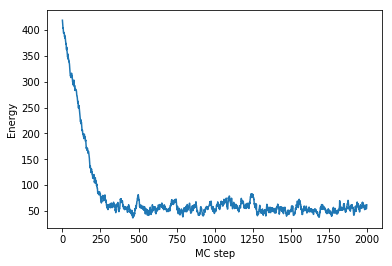

In [9]:
def runMC(temperature,pointCount,mcsteps=2000):
    pointStates=[] #store the coordinate arrays for each MC step here
    energies=[] #store the energy values for each MC step here
    generatedPoints=initializeSystem(pointCount)
    energy=calculateEnergy(generatedPoints)
    pointStates.append(generatedPoints)
    energies.append(energy)
    while len(energies) < mcsteps:
        tempPoints=movePoint(generatedPoints)
        newE=calculateEnergy(tempPoints)
        if newE < energy or random.random() < math.e**((energy-newE)/temperature):
            generatedPoints=tempPoints
            energy=newE
            energies.append(energy)
            pointStates.append(generatedPoints)

    #Don't alter this code, it will help visualize the simulation
    interact(showPlot,index=(0,len(energies)-1),pointStates=fixed(pointStates),energies=fixed(energies))
    p.plot([i for i in range(len(energies))],energies)
    p.ylabel("Energy")
    p.xlabel("MC step")
    p.show()
    
    
runMC(2.0,10)

Given that your simulation ran correctly, you should see a plot with a slider that allows you to slide through the accepted movements of the simulation, as well as a plot of the system energy at each accepted step.  This trace of energy should start high, but then flatten as the simulation equilibriates; this initial dip in energy is referred to as the "burn-in" steps of the simulation and is typically not sampled from as it does not reflect the equilibrium of the system.  Try repeating the simulation, but at higher temperatures.  You will notice that the energy of the system is much less stable at these temperatures, potentially to the point of not reaching equilibrium at all.  While the states generated at these temperatures don't reflect the minimum of the energy function, they are useful for helping the simulation escape local minima of the energy function in search of the global minimum.  Therefore, the most successful simulations employ a wide range of temperatures in finding the global energy minimum.

## 6. Modulating Simulation Temperature
One method of incorporating different temperatures into the Metropolis Monte Carlo simulation is to run several simulations at different temperatures, or "replicas" in parallel and allow swapping of system states between each replica when their energies overlap.  This method, Replica Exchange Monte Carlo (REMC), is how I-TASSER finds near-native protein conformations by minimizing the energy function of the modeling simulation.  However, this method is computationally costly and requires a great deal of fine tuning to ensure that the replicas are in fact swapping states between each other at a reasonable rate.  A simpler approach to incorporating multiple temperatures is the simulated annealing approach, in which the temperature is changed over time in a pattern of descending peaks:

(Insert SA illustration here)

Given this definition of simulated annealing, alter the *runSAMC* which takes in only a number of points and runs the Simulated Annealing Monte Carlo (SAMC) simulation, changing the simulation temperature after each accepted movement according to the simulated annealing temperature curve, which can be generated by the instructor-provided *temperatureCurve* function.

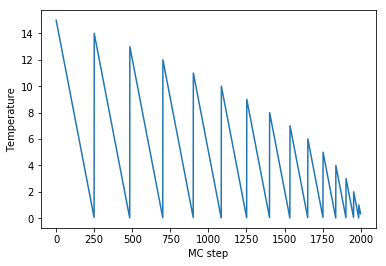

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT05OTksIGRlc2NyaXB0aW9uPXUnaW5kZXgnLCBtYXg9MTk5OSksIE91dHB1dCgpKSwgX2RvbV9jbGFzc2VzPSh1J3dpZGdldC3igKY=


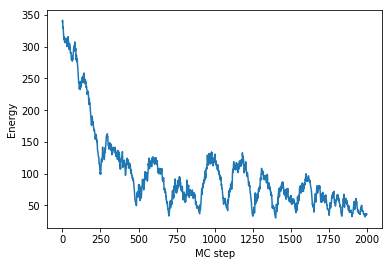

In [10]:
def runSAMC(pointCount,mcsteps=2000):
    generatedPoints=initializeSystem(pointCount)
    energy=calculateEnergy(generatedPoints)
    temps=temperatureCurve(15.0,mcsteps)
    pointStates=[generatedPoints]
    energies=[energy]
    while len(energies) < mcsteps:
        tempPoints=movePoint(generatedPoints)
        newE=calculateEnergy(tempPoints)
        if newE < energy or random.random() < math.e**((energy-newE)/temps[len(energies)]):
            generatedPoints=tempPoints
            energy=newE
            energies.append(energy)
            pointStates.append(generatedPoints)

    #Don't alter this code, it will help visualize the simulation
    interact(showPlot,index=(0,len(energies)-1),pointStates=fixed(pointStates),energies=fixed(energies))
    p.plot([i for i in range(len(energies))],energies)
    p.ylabel("Energy")
    p.xlabel("MC step")
    p.show()
    
    
runSAMC(10)

The energy plot should now clearly show peaks that align with the peaks of the simulated annealing temperature curve.  Since this simulation is so basic, the benefit of implementing simulated annealing isn't very apparent, but this technique is essential to more complex problems such as protein folding.